In [ ]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd            
import seaborn as sns           
import sklearn     
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.special import gammainc
from sklearn.metrics import confusion_matrix
import scipy
from sklearn.preprocessing import normalize
sns.set_theme()
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Постановка задачи
Предоставлены данные, собранные в рамках рекламной кампании некоторого португальского банка, по результатам обзвона клиентов с предложением сделать срочный вклад. Цель: на основе данных о клиенте предсказать, будет ли он готов сделать вклад после рекламного звонка. Источник данных: https://www.kaggle.com/kidoen/bank-customers-data

# Предобработка данных

## 1. Чтение данных

In [2]:
url = "https://raw.githubusercontent.com/ArisovaAnastasia/MachineLearning/master/BankCustomerData.csv"
data = pd.read_csv(url)

Сначала посмотрим на размеры таблицы: каждая строка соответствует одной квартире, каждый столбец соответствует конкретному признаку.

In [3]:
data.shape

(42639, 17)

In [4]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
data.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
42634,21,student,single,secondary,no,2488,no,no,telephone,12,jan,661,2,92,1,success,yes
42635,87,retired,married,primary,no,2190,no,no,telephone,12,jan,512,2,-1,0,unknown,yes
42636,34,blue-collar,married,primary,no,6718,no,no,cellular,13,jan,278,4,97,1,other,no
42637,22,student,single,secondary,no,254,no,no,cellular,13,jan,143,2,-1,0,unknown,yes
42638,32,management,single,tertiary,no,1962,no,no,cellular,13,jan,130,1,-1,0,unknown,no


Tаблица содержит данные о 42.6 тыс. клиентах банка и контакте с ними. Всего имеется 17 признаков:

- `age` - возраст
- `job` - профессия
- `marital` - семейное положение
- `education` - образование
- `balance` - остаток средств
- `default` - есть ли задолженность на кредитной карте
- `housing` - есть ли ипотечный кредит
- `loan` - есть ли кредит на личные цели
- `contact` - куда был произведён рекламный звонок
- `day/month` - день/месяц рекламного звонка
- `duration` - длительность звонка (Примечание: данный признак имеет прямое влияние на цель предсказания, нулевые по длительности разговоры автоматически означают отказ. При обучении модели его необходимо отбросить. )
- `campaign` - число звонков данному клиенту в рамках текущей рекламной кампании
- `pdays` - число дней со звонка по прошлой рекламной кампании (-1 если звонка по ней не было)
- `previous`- число звонков данному клиенту в рамках прошлой рекламной кампании
- `poutcome` - результат прошлой рекламной кампании 

Преобразуем тип соответствующих категориальных признаков в подходящий и рассмотрим индексы каждой категории:

In [6]:
for col in ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month','poutcome','term_deposit']:
    data[col] = data[col].astype('category')
    print(col)
    print(data[col].dtype.categories)
    print('-------------------------------')

job
Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')
-------------------------------
marital
Index(['divorced', 'married', 'single'], dtype='object')
-------------------------------
education
Index(['primary', 'secondary', 'tertiary', 'unknown'], dtype='object')
-------------------------------
default
Index(['no', 'yes'], dtype='object')
-------------------------------
housing
Index(['no', 'yes'], dtype='object')
-------------------------------
loan
Index(['no', 'yes'], dtype='object')
-------------------------------
contact
Index(['cellular', 'telephone', 'unknown'], dtype='object')
-------------------------------
month
Index(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov',
       'oct', 'sep'],
      dtype='object')
-------------------------------
poutcome
Index(['failure', 'other', 'success', 'unknown'], dtype=

Опять же, всё очевидно, кроме, разве что, индекса 'other' в исходе предыдущей рекламной кампании. Возможно, так обозначался исход, когда клиента не удавалось уговорить на вклад, но получалось на что-то ещё? В описании к данным это упущено.

Также возникает вопрос, как поступать с индексами 'unknown'. По своей сути, это пропущенные значения, очевидно, что признаки 'job', 'education', 'contact' мы можем обработать по стандартному сценарию, но можно ли так же поступить с признаком 'poutcome'? Ведь, скорее всего, согласие/несогласие в прошлую кампанию должно коррелировать с текущим согласием/несогласием, а если предложения не было вовсе, то никакой связи с будущим результатом установить нельзя, то есть замена на моду (несогласие, отказ клиента) будет занижать вероятность на успех без какого-либо значительного повода? Вероятно, чтобы это понять, стоит провести эксперимент с заменой и без замены и посмотреть на ложноотрицательные ошибки в каждом случае.

UPD: Оставляем unknown для категории poutcome.
Также заменим значение "-1" для дней, прошедших с последнего звонка, (то есть ситуации когда звонка не было вообще) большим значением, например в год:

In [7]:
data.loc[data['pdays'] == -1, 'pdays'] = 730

## 2. Визуализация и статистика

Получим общую информацию о числовых и категориальных признаках: 

In [8]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000
mean,40.788808,1331.863951,15.854781,255.957504,2.816412,652.756397,0.465442
std,10.200236,3011.537676,8.293901,258.361368,3.163564,185.739101,2.166705
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,33.000000,62.000000,8.000000,101.000000,1.000000,730.000000,0.000000
50%,39.000000,429.000000,16.000000,177.000000,2.000000,730.000000,0.000000
75%,48.000000,1381.500000,21.000000,315.000000,3.000000,730.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,730.000000,275.000000


In [9]:
data.describe(include=['category'])

,job,marital,education,default,housing,loan,contact,month,poutcome,term_deposit
count,42639,42639,42639,42639,42639,42639,42639,42639,42639,42639
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9536,25868,22066,41828,24590,35554,27218,13532,36085,38678


Здесь видно, что формально пропущенных значений, кроме "Unknown" в некоторых категориальных признаках, нет. Заодно можем увидеть несколько демографических фактов, вроде среднего возраста, самого частого рода занятий и т.д.
Построим матрицу корреляции для числовых признаков:

In [10]:
corr_mat = data.corr()
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.088716,-0.009869,-0.016529,0.008296,0.022203,-0.016279
balance,0.088716,1.000000,0.004696,0.016721,-0.013358,-0.026744,0.005194
day,-0.009869,0.004696,1.000000,-0.032557,0.165906,0.073075,-0.048445
duration,-0.016529,0.016721,-0.032557,1.000000,-0.085640,0.009294,-0.007730
campaign,0.008296,-0.013358,0.165906,-0.085640,1.000000,0.098146,-0.024374
pdays,0.022203,-0.026744,0.073075,0.009294,0.098146,1.000000,-0.492016
previous,-0.016279,0.005194,-0.048445,-0.007730,-0.024374,-0.492016,1.000000


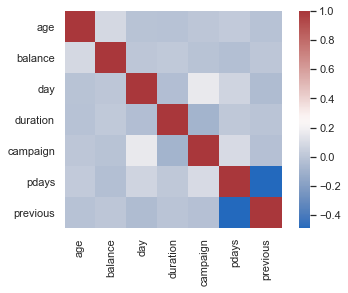

In [11]:
sns.heatmap(corr_mat, square=True, cmap='vlag')
pass

Как и предполагалось, никакой заметной корреляции увидеть не удаётся. Разве что между числом звонков в прошлый раз, и числом дней прошедших с прошлого звонка - 0/365 соответственно для многих клиентов. Эта связь была заведомо известна и никакой новой информации не даёт.

No handles with labels found to put in legend.


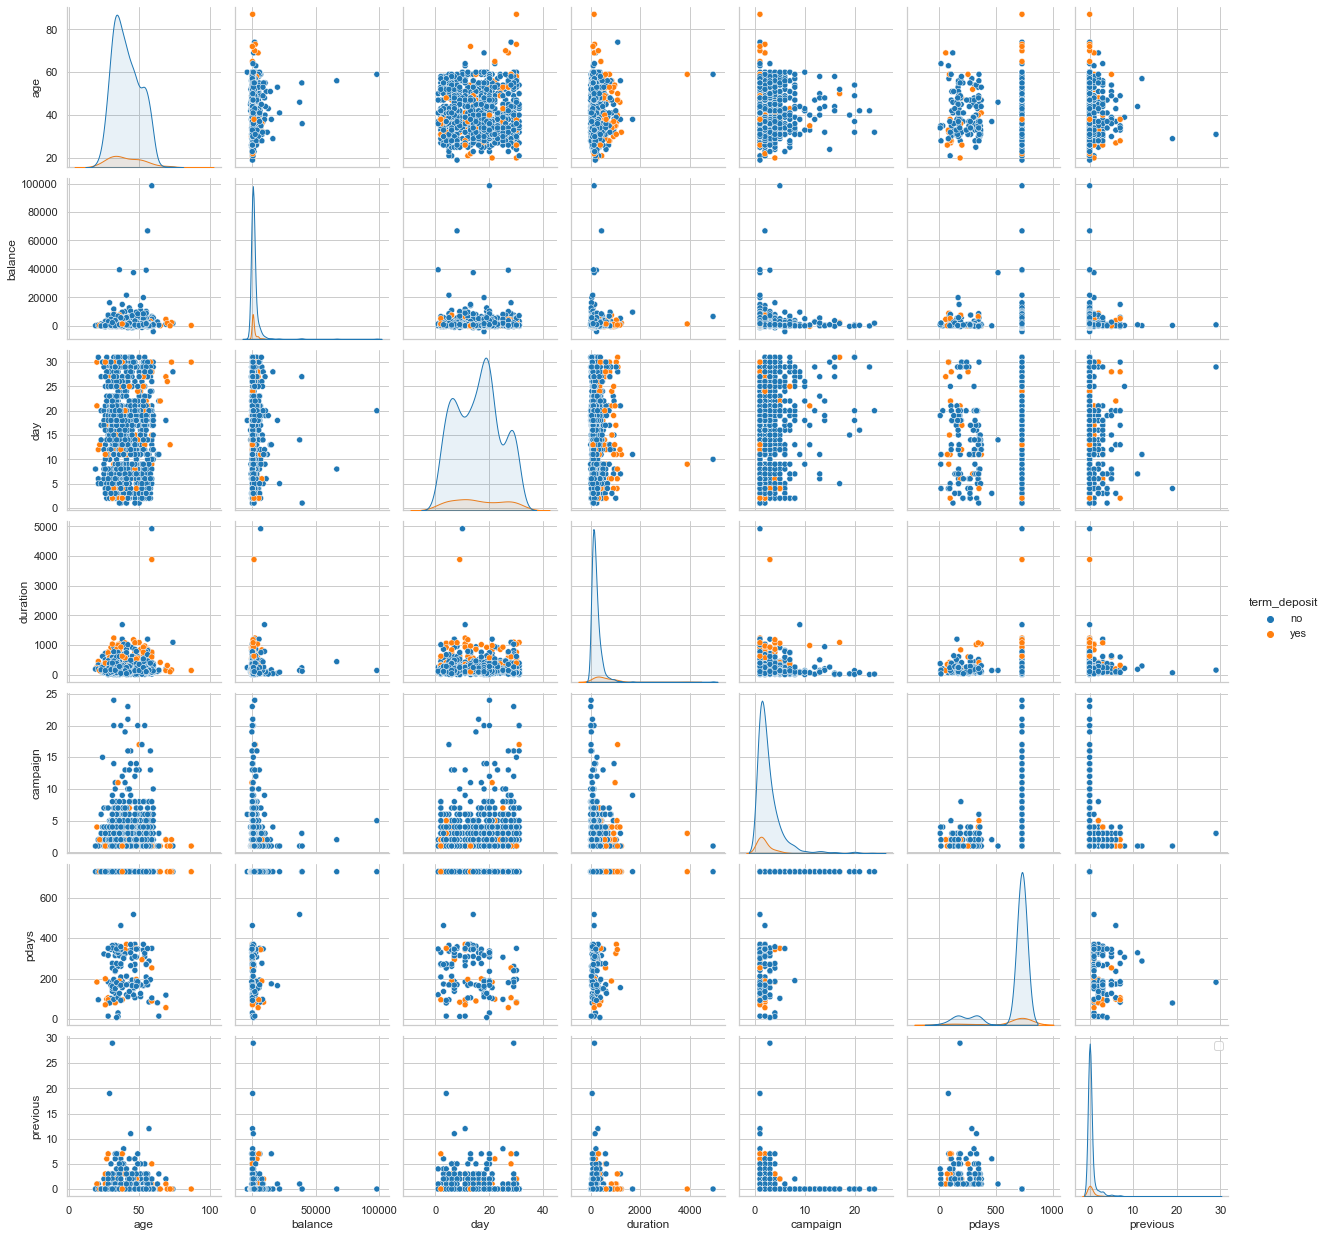

In [12]:
np.random.seed(21)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
sns.pairplot(data.iloc[random_subset], diag_kind = 'auto',hue='term_deposit',diag_kws={'alpha':0.1})
plt.legend()
pass

Здесь сразу же можно сделать простой вывод, что чем более длительным был звонок, тем чаще результатом было согласие. К сожалению, воспользоваться этим фактом никак нельзя, потому что длительность звонка до его совершения неизвестна. Большинству людей либо до этого не звонили ни разу, либо они не стали разговаривать. Распределение по дням более-менее равномерное с пиками 10, 20, 30 числа, что интересно. На гистограммы возраста и баланса на счёте, а также на их совместное распределение взглянем внимательнее.

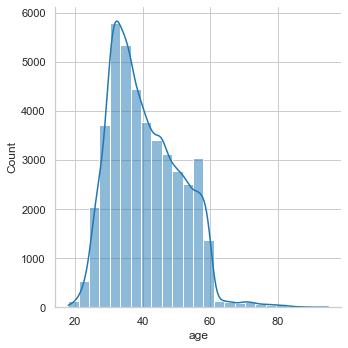

In [13]:
sns.displot(data['age'], bins=25,kde=True)
pass

На гистограмме возраста заметны предпочтения банка при обзвоне. Действительно, людям за 60 банк старается не звонить по вопросу вкладов. Также, явно виден пик по возрасту, по-видимому, предполагается, что люди около 30 более всего заинтересованы во вкладах.

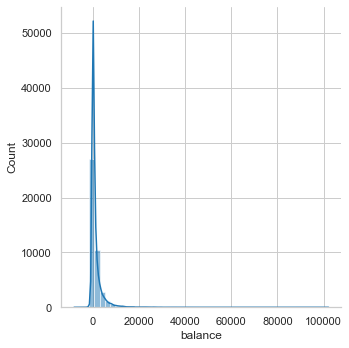

In [14]:
sns.displot(data['balance'], bins=50,kde=True)
pass

Гистограмма баланса похожа на гамма-распределение по своему виду. Явно выделяется пик - у большинства клиентов, которым звонили, баланс на счёте нулевой.

Теперь посмотрим на статистику связанную с категориальными признаками.

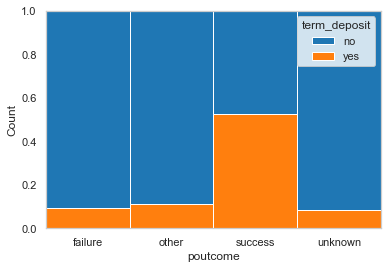

In [15]:
sns.histplot(x='poutcome',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

На данной гистограмме заметна сильная связь между прошлым согласием и текущим согласием. Второй раз люди делают вклад в 4 раза
охотнее.

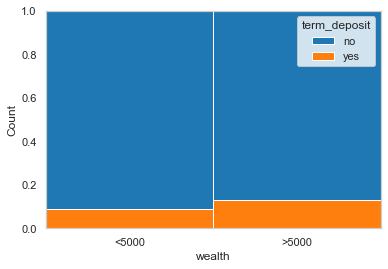

In [16]:
def wealthy (row):
    if (row['balance'] > 5000):
        return '>5000'
    else:
        return '<5000'
data['wealth'] = data.apply (lambda row: wealthy(row), axis=1)
sns.histplot(x='wealth',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
data = data.drop('wealth',  axis=1)
pass

Люди с большим количеством денег делают больше вкладов, что является вполне интуитивным выводом. 

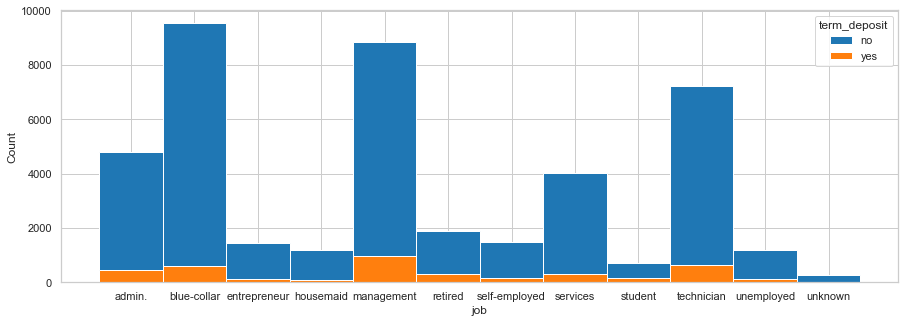

In [17]:
plt.figure(figsize=(15,5))
sns.histplot(x='job',hue='term_deposit',data=data,multiple = 'stack',alpha = 1)
pass

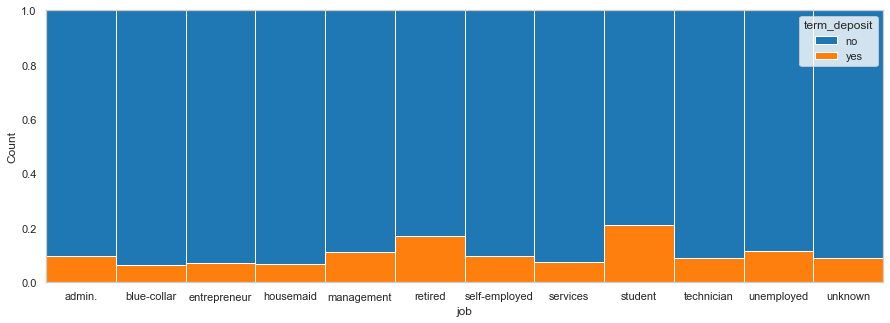

In [18]:
plt.figure(figsize=(15,5))
sns.histplot(x='job',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

На двух гистограммах выше видно, что в банке чаще стараются звонить клиентам, занятым на реальной работе, а предпринимателям, домохозяйкам, пенсионерам, самозанятым, студентам звонят в несколько раз реже. 
 
Возможно, банку следует чаще звонить пенсионерам и студенам, поскольку на вклады они соглашаются почти в два раза чаще, чем остальные. В остальном от рода деятельности процент согласия варьируется незначительно.

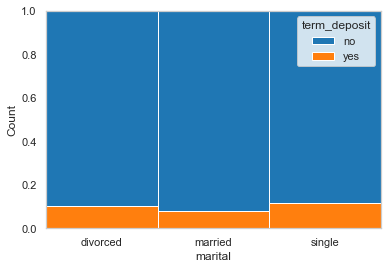

In [19]:
sns.histplot(x='marital',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

От семейного статуса зависимость незначительная, однако люди в браке всё же согласны делать вклады реже, что странно.

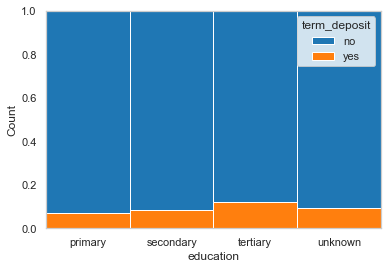

In [20]:
sns.histplot(x='education',hue='term_deposit',data=data,multiple = 'fill',alpha = 1)
pass

Тут можно видеть, что при повышении уровня образования возрастает процент согласия на вклад.

## 3. Обработка выбросов
Из всех числовых признаков только возраст и баланс счёта могут обладать выбросами, построим диаграмму рассеивания:

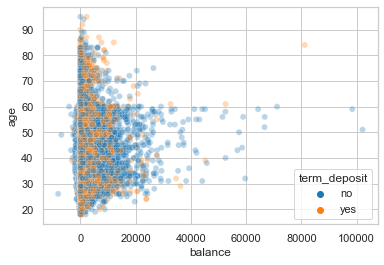

In [21]:
sns.scatterplot(x = 'balance',y ='age',hue='term_deposit',alpha=0.3,data = data)
pass

Видим, что выбросы есть для баланса, уберём 0.1% граничных данных для баланса и построим диаграмму рассеивания заново:

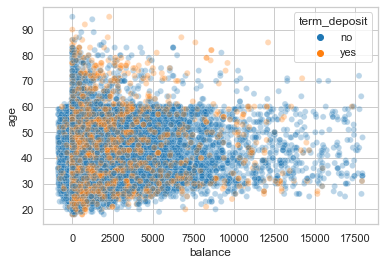

In [22]:
rows_to_drop = data[
    (data['balance'] < data['balance'].quantile(0.005)) | (data['balance'] > data['balance'].quantile(0.995))].index
data = data.drop(rows_to_drop)
data.shape
sns.scatterplot(x = 'balance',y ='age',hue='term_deposit',alpha=0.3,data = data)
pass

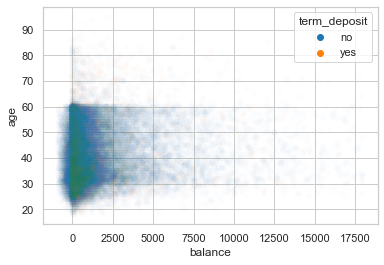

In [23]:
sns.scatterplot(x = 'balance',y ='age',hue='term_deposit',alpha=0.01,data = data)
pass

Какой-либо зависимости между возрастом и балансом на счёте проследить не удаётся, хотя поначалу кажется, что у людей 60 лет и старше в среднем меньше денег на счёте, но на самом деле им звонили в целом намного реже, что видно на прозрачной диаграмме.

Также здесь видна довольно занятная аномалия: ни у одного клиента старше 60 лет нет отрицательного баланса на счёте. Возможно, что это влияние самого процесса обзвона, то есть людям старше 60 с задолженностью на счёте попросту не звонили, что объясняет эту искусственную границу на диаграмме.

## 4. Обработка пропущенных значений

Заменим пропущенные значения категориальных признаков 'job', 'education', 'contact' на соответствующие моды:

In [24]:
data.replace({'job':"unknown",'education':"unknown",'contact':"unknown"},{'job':data['job'].mode().iloc[0],'education':data['education'].mode().iloc[0],'contact':data['contact'].mode().iloc[0]}, inplace=True)
for col in ['job', 'education', 'contact']:
    data[col].cat.remove_unused_categories(inplace=True)

D:\Program\anaconda\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


При этом категорию 'unknown' признака 'poutcome' оставим без изменений, поскольку сообщается информация о том, что во время предыдущей рекламной кампании с клиентом работы не велось.

## 5. Обработка категориальных признаков
Закодируем бинарные признаки с помощью числовых:

In [25]:
data['default'] = pd.factorize(data['default'], sort = True)[0]
data['housing'] = pd.factorize(data['housing'],sort = True)[0]
data['loan'] = pd.factorize(data['loan'],sort = True)[0]
data['term_deposit'] = pd.factorize(data['term_deposit'],sort = True)[0]

Оставшиеся категориальные признаки закодируем с помощью метода бинаризации:

In [26]:
for col in ['job', 'marital', 'education', 'contact', 'month','poutcome']:
    dummies = pd.get_dummies(data[col])
    data = pd.concat((data, dummies), axis=1)
    data = data.drop([col],  axis=1)

## 6. Нормализация признаков
Выполним стандартизацию всех признаков:

In [27]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)

# Решение задачи классификации

## 7. Разбиение на обучающую и тестовую выборки

In [28]:
X = data_stand.drop(['term_deposit','duration'], axis=1)
y = data[['term_deposit']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.25, random_state = 21)

## 8. Классификатор kNN

   size  train_score  test_score
0   1.0     1.000000    0.856439
1   3.0     0.926527    0.898038
2   5.0     0.917967    0.908083
3   7.0     0.915598    0.909978
4   9.0     0.914366    0.909125
5  11.0     0.913513    0.910262


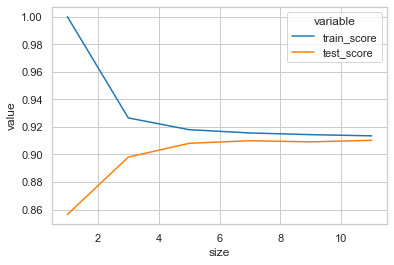

In [29]:
scores = pd.DataFrame({'size':[],'train_score':[],'test_score':[]})
for i in range(1,12,2):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train1, y_train1.values.ravel())
    scores = scores.append({'size':i,'train_score':knn.score(X_train1, y_train1),'test_score':knn.score(X_test1, y_test1)},ignore_index=True)
print(scores)
sns.lineplot(x='size', y='value', hue='variable', data=pd.melt(scores, ['size']))
pass

Здесь видно, что обе ошибки асимптотически приближаются к лучшей возможной точности для данного подхода (метод kNN и отсутствие борьбы с несбалансированностью).

Посмотрим confusion matrix для лучшей по точности модели из 11 соседей:

In [30]:
print(confusion_matrix(y_test1,knn.predict(X_test1),normalize='true'))

[[0.98935615 0.01064385]
 [0.87113402 0.12886598]]


Почти всегда предполагается, что вклад не взят, и этот исход, соответственно предсказывается идеально. По-видимому, при дальнейшем увеличении числа соседей, мы всегда будем предсказывать отказ. Однако, исходя из анализа ситуации, намного выгоднее предсказывать согласие чаще и ошибаться с несогласием, ведь таким образом, банк будет получать больше вкладов ценой нескольких безрезультатных звонков.

In [31]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train1, y_train1.values.ravel())
print(confusion_matrix(y_test1,knn.predict(X_test1),normalize='true'))

[[0.92246687 0.07753313]
 [0.79587629 0.20412371]]


Просмотрим ту же матрицу для модели из 1 соседа. Несмотря на снижение точности мы предсказываем почти в два раза больше согласий, что делает эту модель предпочтительнее.

## 9. Классификатор Random Forest

In [32]:
rf = RandomForestClassifier()
rf.fit(X_train1, y_train1.values.ravel())
print(confusion_matrix(y_test1,rf.predict(X_test1),normalize='true'))

[[0.98987791 0.01012209]
 [0.87731959 0.12268041]]


Классификатор обладает той же проблемой, что была выше.

## 10. Борьба с несбалансированностью

Для повышения правильности предсказания согласия, модифицируем тренировочный датасет таким образом, чтобы в нём распределение по классам было равным. Также посмотрим на изначальное распределение классов.

NameError: name 'SMOTE' is not defined

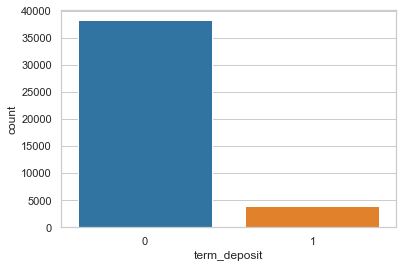

In [33]:
sns.countplot(x = 'term_deposit', data = y)
X_os, y_os = SMOTE(sampling_strategy=0.2).fit_sample(X_train1, y_train1.values.ravel())
X_os, y_os = RandomUnderSampler(sampling_strategy=0.2).fit_sample(X_os, y_os)
X_os = pd.DataFrame(X_os)
y_os = pd.DataFrame(y_os)

(X_os.shape,y_os.shape)

Теперь повторим опыт:

In [ ]:
scores = pd.DataFrame({'size':[],'train_score':[],'test_score':[]})
for i in range(1,12,2):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_os, y_os.values.ravel())
    scores = scores.append({'size':i,'train_score':knn.score(X_os, y_os),'test_score':knn.score(X_test1, y_test1)},ignore_index=True)
    print('Size: ',i)
    print(confusion_matrix(y_test1,knn.predict(X_test1),normalize='true'))
print(scores)
sns.lineplot(x='size', y='value', hue='variable', data=pd.melt(scores, ['size']))
pass

В данном случае лучшим оказывается классификатор с числом соседей 5. Он предсказывает 26.5% согласий и имеет общую точность 87.6%.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_os, y_os.values.ravel())
y_pr = rf.predict(X_test1)

In [ ]:
print("Train Accuracy :", rf.score(X_os, y_os))
print("Test Accuracy :", rf.score(X_test1, y_test1))
print("CM:\n")
print(confusion_matrix(y_test1,y_pr,normalize='true'))

Случайный лес на на сбалансированном датасете работает несколько лучше, но хуже, чем kNN с числом соседей 5.

Также в качестве эксперимента используем модели, где для классов указывается вес, в зависимости от их соотношения.

In [ ]:
rf_balanced = RandomForestClassifier(n_estimators=150, class_weight='balanced')
rf_balanced.fit(X_train1, y_train1.values.ravel())
print(confusion_matrix(y_test1,rf_balanced.predict(X_test1),normalize='true'))

In [ ]:
from sklearn.svm import SVC
svc_balanced = SVC(kernel='linear', class_weight='balanced')
svc_balanced.fit(X_train1, y_train1.values.ravel())
print(confusion_matrix(y_test1,svc_balanced.predict(X_test1),normalize='true'))

In [ ]:
np.mean(wclf.predict(X_test1) == np.array(y_test1).ravel())

# Выводы по части 1

В результате работы над первой частью можно сделать следующие выводы: (кроме тех, что были сделаны ранее)

- Наиболее важным является не повышение общей точности, а правильность предсказания согласия.
- Эта задача не является простой, очень велик случайный фактор, а все данные, что имеются у банка, не сильно влияют на исход звонка, отсюда малая точность предсказаний согласия.
- Борьба с несбалансированностью классов не дала существенного эффекта, поднимая для лучшего классификатора точность предсказания согласий на 6%, а общую точность на 2%.
- kNN в целом работает на данной задаче намного лучше RandomForest, однако для второго не подбирались наилучшие параметры.
- По поведению классификатора с большим числом соседей можно сказать, что точки, где исход звонка положительный, довольно редко собираются в кластеры, иначе точность их предсказания была бы выше 12%. Такое поведение показывает, что они в основном расположены произвольно в массе точек.
- Наилучшим классификатором по результатам оказался сбалансированный SVM с точностью предсказания согласия в 40.9%

# Сокращение размерности

## 11. Метод главных компонент

In [ ]:
X = data_stand.drop(['term_deposit','duration'], axis=1)
y = data[['term_deposit']]

Здесь заметно, что в результате облако точек справа будет являться согласием, а слева - отказом. Наиболее важными в порядке убывания оказываются признаки: 
- poutcome
- pdays
- previous
- education
- housing
- job

Применим лучший классификатор из прошлой части:

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_tr, y_tr.values.ravel())

print("Train accuracy: ", knn.score(X_tr, y_tr))
print("Test accuracy: ", knn.score(X_te, y_te))
print(confusion_matrix(y_te,knn.predict(X_te),normalize='true'))

Получилось ужасно, угадано всего 4% согласий. То есть двух компонент после PCA явно недостаточно для работы.

## 12. Линейный дискриминантный анализ

In [ ]:
lda = LinearDiscriminantAnalysis(n_components = 1)
res = lda.fit_transform(X,y.values.ravel())
X_tr, X_te, y_tr, y_te = train_test_split(res, y, test_size = 0.25, random_state = 22)
print(res.shape)

In [ ]:
scores = pd.DataFrame({'size':[],'train_score':[],'test_score':[]})
for i in range(1,12,2):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_tr, y_tr.values.ravel())
    scores = scores.append({'size':i,'train_score':knn.score(X_tr, y_tr),'test_score':knn.score(X_te, y_te)},ignore_index=True)
    print(confusion_matrix(y_te,knn.predict(X_te),normalize='true'))
print(scores)
sns.lineplot(x='size', y='value', hue='variable', data=pd.melt(scores, ['size']))
pass

Для одномерного результата работы LDA наилучшим оказывается kNN с k=1. Однако, и общая точность, и точность предсказания согласия ниже, чем без сокращения размерности.

## 13. Моделирование с разным количеством компонент (PCA)

In [ ]:
scores = pd.DataFrame({'size':[],'train_score':[],'test_score':[],'dep_score':[]})
for i in range(1,40):
    pca = PCA(n_components = i)
    res = pca.fit(X).transform(X)
    X_tr, X_te, y_tr, y_te = train_test_split(res, y, test_size = 0.25, random_state = 22)
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_tr, y_tr.values.ravel())
    scores = scores.append({'size':i,'train_score':knn.score(X_tr, y_tr),'test_score':knn.score(X_te, y_te),'dep_score':confusion_matrix(y_te,knn.predict(X_te),normalize='true')[1,1]},ignore_index=True)
print(scores)

In [ ]:
sns.lineplot(x='size', y='value', hue='variable', data=pd.melt(scores, ['size','train_score','test_score']))
pass

# Выводы по части 2

В результате работы над второй частью можно сделать следующие выводы: (кроме тех, что были сделаны ранее)
- Метод сокращения размерности в целом плохо подходит для этой задачи, точность предсказания согласия существенно ниже, а в лучшем случае не превышает 15%. При этом общая точность вообще практически не меняется при изменении числа компонент.
- Несмотря на то, что меньше десятка признаков по оценке после PCA считаются наиболее важными, видно, что даже при оставлении 40 главных компонент точность предсказания согласия, чем при всех, что говорит о важности всех признаков.